In [1]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from neuralprophet import NeuralProphet
from arima import ARIMA

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import quantnn
import run_experiment


import torch
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Data

In [2]:
dataset = "synthetic"

In [3]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [4]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

In [5]:
# 90, 80, 70, 60, 50 % prediction intervals
lower_quantiles = [0.05, 0.1, 0.15, 0.2, 0.25]
upper_quantiles = [0.95, 0.9, 0.85, 0.8, 0.75]

## The idea is
That we create prediction intervals for the ACI method on all models. Then we look into what the impact is of the quantile estimate.

In [6]:
# We get a plot with on the x-axis different quantile estimates
# and on the y-axis the PIAW metric, but we also compute PICP

In [7]:
ACI_pinaw = np.zeros((len(lower_quantiles), 3))  # 3 models with ACI
ACI_picp = np.zeros((len(lower_quantiles), 3))  # 3 models with ACI

In [8]:
def predict_linear(quantiles: dict):
    QLR_predictions = {}
        
    # fit each prompted quantile and predict on all samples

    QLR = QuantileLinearRegressor(quantiles=list(quantiles.values()))
    QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
            df_train["y"].to_numpy())

    y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
    print(y_pred.shape)

    QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
    QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
    QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)
    
    return QLR_predictions

def predict_forest(quantiles: dict):
    X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
    X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
    X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
    X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()
    
    QFR_predictions = {}
    
    QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=list(quantiles.values()), max_depth=2, differencing=False)
    QFR.fit(X_train, y_train)
    
    y_pred = QFR.predict(X_all)
    
    QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
    QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
    QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)
    
    return QFR_predictions

def predict_neuralnet(quantiles: dict):
    layers = 4
    neurons = 256
    activation = "relu"
    model = (layers, neurons, activation)
    qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)
    
    logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)
    
    y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

    NN_predictions = {}
    NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
    NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
    NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)
    
    return NN_predictions


In [9]:
linear_metrics = []
forest_metrics = []
nn_metrics = []

In [10]:
for (l, u) in zip(lower_quantiles, upper_quantiles):
    interval = u - l
    print(f"Interval: {interval}%")
    
    linear = predict_linear({"lower": l, "middle": 0.5, "upper": u})
    forest = predict_forest({"lower": l, "middle": 0.5, "upper": u})
    nn = predict_neuralnet({"lower": l, "middle": 0.5, "upper": u})
    
    linear_metrics.append(list(compute_aci(linear, df, df_train, df_val, df_test, tvt_split, T, gamma=0.005)))
    forest_metrics.append(list(compute_aci(forest, df, df_train, df_val, df_test, tvt_split, T, gamma=0.005)))
    nn_metrics.append(list(compute_aci(nn, df, df_train, df_val, df_test, tvt_split, T, gamma=0.005)))
    

linear_metrics = np.array(linear_metrics)
forest_metrics = np.array(forest_metrics)
nn_metrics = np.array(nn_metrics)
    

Interval: 0.8999999999999999%
(2998, 3)


2998it [00:22, 133.04it/s]


Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        11.649        
      2   0.0005         3.025        
      3   0.0005         2.237        
      4   0.0005         1.834        
      5   0.0005         1.753        
      6   0.0005         1.721        
      7   0.0005         1.717        
      8   0.0005         1.674        
      9   0.0005         1.602        
     10   0.0005         1.532        
     11   0.0005         1.486        
     12   0.0005         1.458        
     13   0.0005         1.452        
     14   0.0005         1.431        
     15   0.0005         1.440

[10:52:37] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=191848;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=389837;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

Interval: 0.8%
(2998, 3)


2998it [00:22, 133.66it/s]

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        12.434        
      2   0.0005         3.668        
      3   0.0005         2.493        
      4   0.0005         2.190        
      5   0.0005         2.084        
      6   0.0005         2.044        
      7   0.0005         2.039        
      8   0.0005         2.006        
      9   0.0005         1.940        
     10   0.0005         1.869        
     11   0.0005         1.803        
     12   0.0005         1.801        
     13   0.0005         1.786        
     14   0.0005         1.811        
     15   0.0005         1.785

Interval: 0.7%
(2998, 3)


2998it [00:19, 153.25it/s]

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        11.104        
      2   0.0005         4.032        
      3   0.0005         2.567        
      4   0.0005         2.360        
      5   0.0005         2.280        
      6   0.0005         2.273        
      7   0.0005         2.273        
      8   0.0005         2.259        
      9   0.0005         2.237        
     10   0.0005         2.190        
     11   0.0005         2.140        
     12   0.0005         2.104        
     13   0.0005         2.090        
     14   0.0005         2.099        
     15   0.0005         2.095

Interval: 0.6000000000000001%
(2998, 3)


2998it [00:19, 153.63it/s]

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        11.724        
      2   0.0005         4.244        
      3   0.0005         2.727        
      4   0.0005         2.532        
      5   0.0005         2.466        
      6   0.0005         2.436        
      7   0.0005         2.428        
      8   0.0005         2.404        
      9   0.0005         2.371        
     10   0.0005         2.356        
     11   0.0005         2.303        
     12   0.0005         2.307        
     13   0.0005         2.304        
     14   0.0005         2.290        
     15   0.0005         2.249

Interval: 0.5%
(2998, 3)


2998it [00:19, 151.43it/s]

Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        14.128        
      2   0.0005         4.689        
      3   0.0005         2.948        
      4   0.0005         2.656        
      5   0.0005         2.608        
      6   0.0005         2.563        
      7   0.0005         2.570        
      8   0.0005         2.565        
      9   0.0005         2.586        
     10   0.0005         2.563        
     11   0.0005         2.558        
     12   0.0005         2.561        
     13   0.0005         2.479        
     14   0.0005         2.496        
     15   0.0005         2.473

Linear

In [11]:
picp_linear = linear_metrics[:, 2]  # PICP
picp_linear

array(['0.9966666666666667', '0.9966666666666667', '0.9966666666666667',
       '0.9966666666666667', '0.9966666666666667'], dtype='<U32')

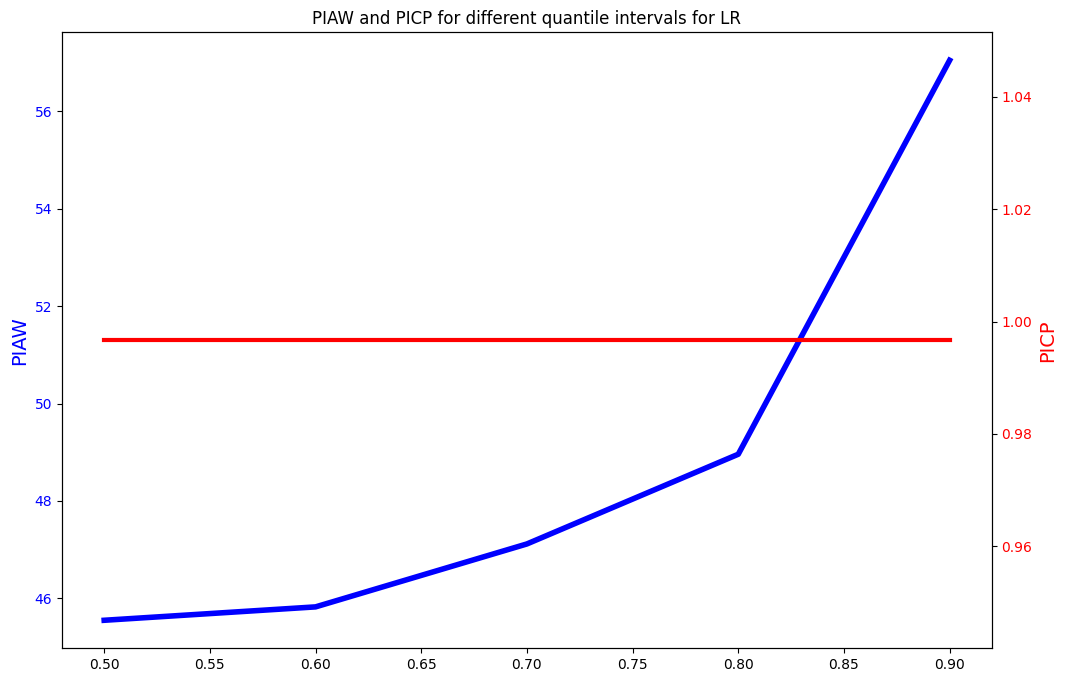

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax2 = ax1.twinx()

intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_linear = linear_metrics[:, 3]  # PIAW
picp_linear = linear_metrics[:, 2]  # PICP
# plot the piaw
ax1.plot(intervals, piaw_linear.astype(float), label="QLR", color="blue", lw=4)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax1.set_ylabel("PIAW",color="blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")

# plot the picp
ax2.plot(intervals, picp_linear.astype(float), label="QLR", color="red", lw=3)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax2.set_xlabel("quantile interval")
ax2.set_ylabel("PICP", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_title("PIAW and PICP for different quantile intervals for LR")
plt.show()

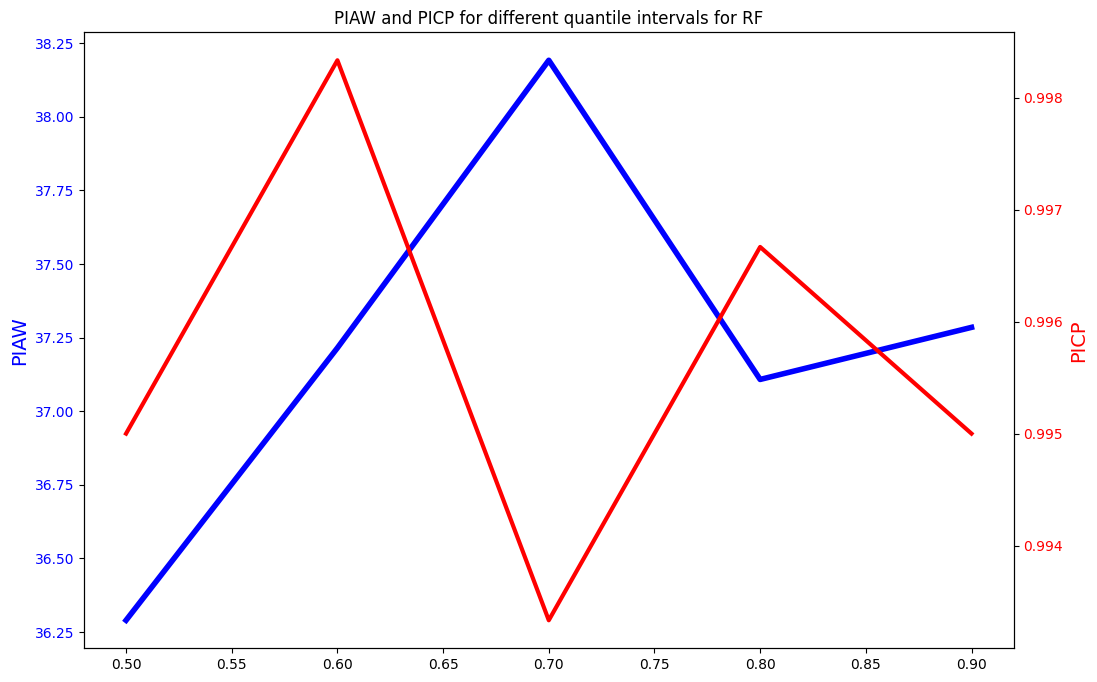

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax2 = ax1.twinx()

intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_forest = forest_metrics[:, 3]  # PIAW
picp_forest = forest_metrics[:, 2]  # PICP
# plot the piaw
ax1.plot(intervals, piaw_forest.astype(float), label="QLR", color="blue", lw=4)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax1.set_ylabel("PIAW",color="blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")

# plot the picp
ax2.plot(intervals, picp_forest.astype(float), label="QLR", color="red", lw=3)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax2.set_xlabel("quantile interval")
ax2.set_ylabel("PICP", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_title("PIAW and PICP for different quantile intervals for RF")
plt.show()

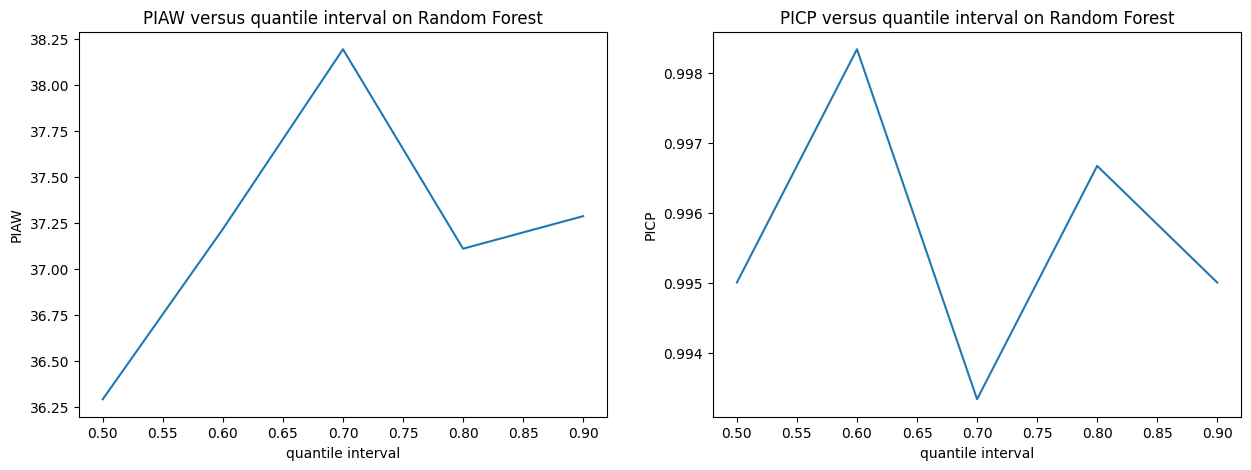

In [14]:
intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_forest = forest_metrics[:, 3]  # PIAW
picp_forest = forest_metrics[:, 2]  # PICP
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# plot the piaw
axs[0].plot(intervals, piaw_forest.astype(float), label="QLR")
axs[0].set_title("PIAW versus quantile interval on Random Forest")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[0].set_xlabel("quantile interval")
axs[0].set_ylabel("PIAW")


# plot the picp
axs[1].plot(intervals, picp_forest.astype(float), label="QLR")
axs[1].set_title("PICP versus quantile interval on Random Forest")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[1].set_xlabel("quantile interval")
axs[1].set_ylabel("PICP")

plt.show()

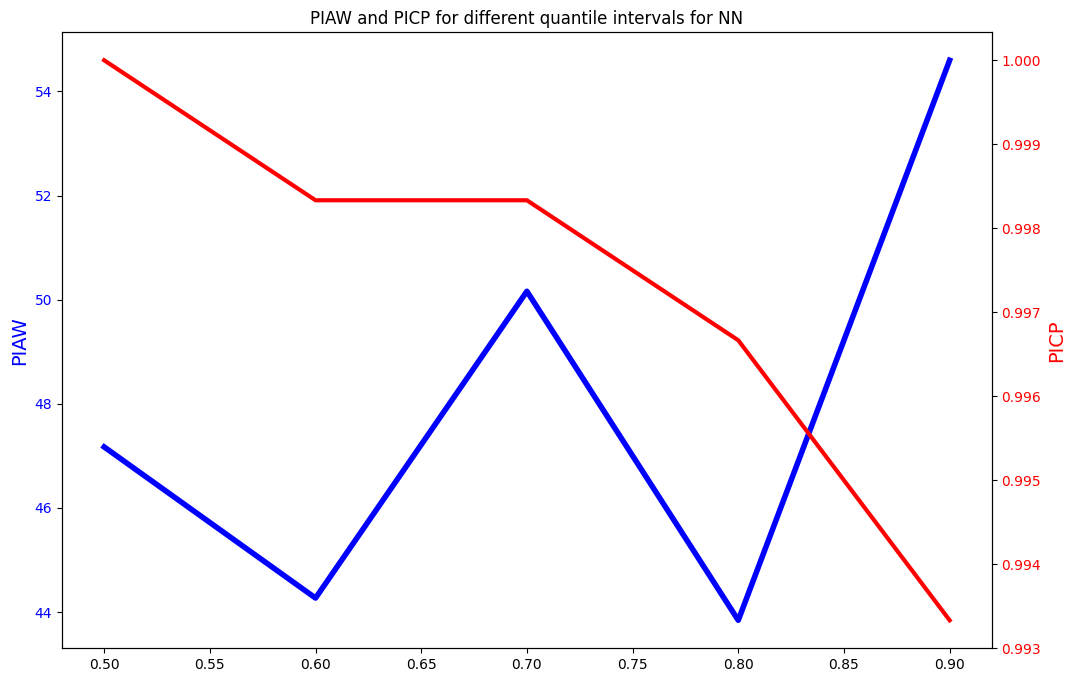

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax2 = ax1.twinx()

intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_nn = nn_metrics[:, 3]  # PIAW
picp_nn = nn_metrics[:, 2]  # PICP
# plot the piaw
ax1.plot(intervals, piaw_nn.astype(float), label="QLR", color="blue", lw=4)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax1.set_ylabel("PIAW",color="blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")

# plot the picp
ax2.plot(intervals, picp_nn.astype(float), label="QLR", color="red", lw=3)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax2.set_xlabel("quantile interval")
ax2.set_ylabel("PICP", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_title("PIAW and PICP for different quantile intervals for NN")
plt.show()

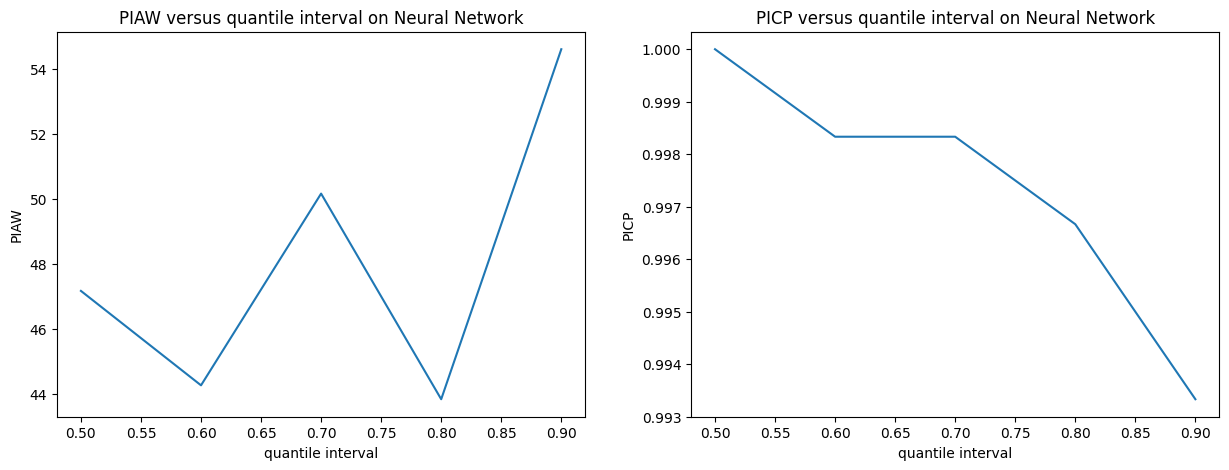

In [16]:
intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_nn = nn_metrics[:, 3]  # PIAW
picp_nn = nn_metrics[:, 2]  # PICP
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# plot the piaw
axs[0].plot(intervals, piaw_nn.astype(float), label="QLR")
axs[0].set_title("PIAW versus quantile interval on Neural Network")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[0].set_xlabel("quantile interval")
axs[0].set_ylabel("PIAW")


# plot the picp
axs[1].plot(intervals, picp_nn.astype(float), label="QLR")
axs[1].set_title("PICP versus quantile interval on Neural Network")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[1].set_xlabel("quantile interval")
axs[1].set_ylabel("PICP")

plt.show()

In [17]:
picp_linear

array(['0.9966666666666667', '0.9966666666666667', '0.9966666666666667',
       '0.9966666666666667', '0.9966666666666667'], dtype='<U32')

In [19]:
picp_ax_range = [0.9, 1.0]

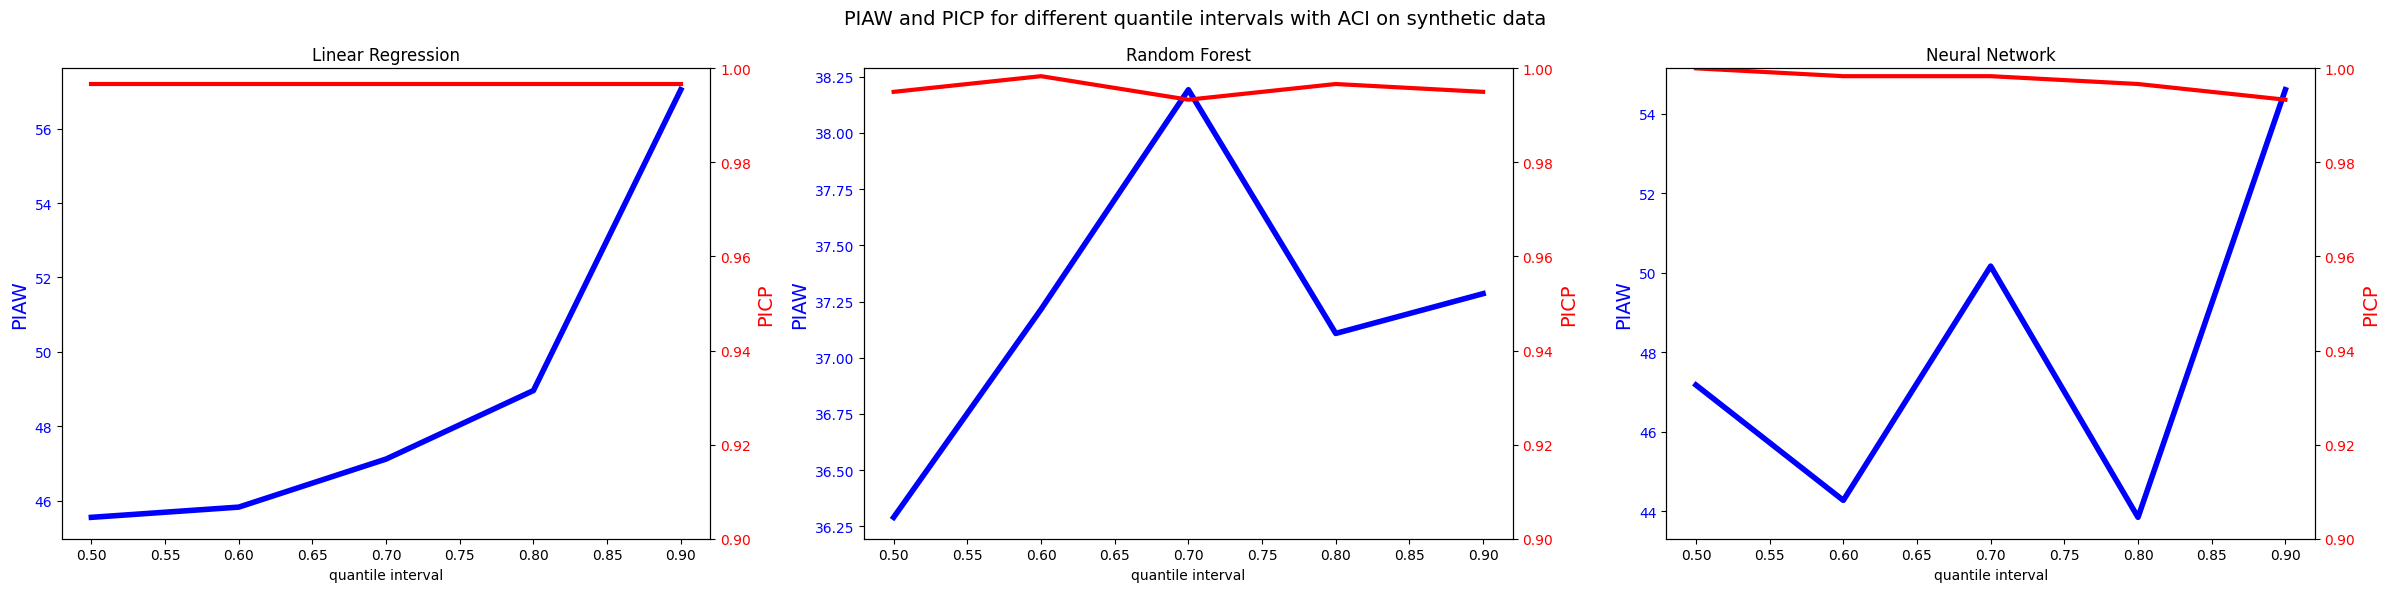

In [20]:
fig, axs = plt.subplots(1,3, figsize=(24, 6))

ax1 = axs[0]
ax2 = axs[0].twinx()

intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_linear = linear_metrics[:, 3]  # PIAW
picp_linear = linear_metrics[:, 2]  # PICP
# plot the piaw
ax1.plot(intervals, piaw_linear.astype(float), label="QLR", color="blue", lw=4)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax1.set_ylabel("PIAW",color="blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("quantile interval")

# plot the picp
ax2.plot(intervals, picp_linear.astype(float), label="QLR", color="red", lw=3)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax2.set_xlabel("quantile interval")
ax2.set_ylabel("PICP", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_title("Linear Regression")
ax2.set_ylim(0.9, 1)  




ax1 = axs[1]
ax2 = axs[1].twinx()

intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_forest = forest_metrics[:, 3]  # PIAW
picp_forest = forest_metrics[:, 2]  # PICP
# plot the piaw
ax1.plot(intervals, piaw_forest.astype(float), label="QLR", color="blue", lw=4)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax1.set_ylabel("PIAW",color="blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("quantile interval")

# plot the picp
ax2.plot(intervals, picp_forest.astype(float), label="QLR", color="red", lw=3)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax2.set_xlabel("quantile interval")
ax2.set_ylabel("PICP", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_title("Random Forest")
ax2.set_ylim(0.9, 1)  

ax1 = axs[2]
ax2 = axs[2].twinx()

intervals = [u-l for (l, u) in zip(lower_quantiles, upper_quantiles)]
piaw_nn = nn_metrics[:, 3]  # PIAW
picp_nn = nn_metrics[:, 2]  # PICP
# plot the piaw
ax1.plot(intervals, piaw_nn.astype(float), label="QLR", color="blue", lw=4)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax1.set_ylabel("PIAW",color="blue", fontsize=14)
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("quantile interval")

# plot the picp
ax2.plot(intervals, picp_nn.astype(float), label="QLR", color="red", lw=3)
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
ax2.set_xlabel("quantile interval")
ax2.set_ylabel("PICP", color="red", fontsize=14)
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_title("Neural Network")
ax2.set_ylim(0.9, 1)  

fig.suptitle("PIAW and PICP for different quantile intervals with ACI on synthetic data", fontsize=14)
fig.tight_layout()
plt.show()